/tmp/ipykernel_144/2587559551.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Crash_cleaned['DateOfCrash'] = pd.to_datetime(Crash_cleaned['DateOfCrash'])
/tmp/ipykernel_144/2587559551.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Crash_cleaned['DateOfCrash'] = Crash_cleaned['DateOfCrash'].dt.tz_convert('America/New_York')
/tmp/ipykernel_144/2587559551.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

FileNotFoundError: [Errno 2] No such file or directory: 'figures/crash_vs_time.png'

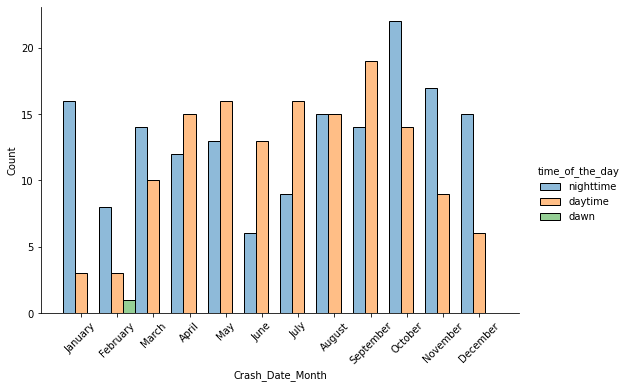

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime

from astral import LocationInfo
from astral.sun import sun

Crash = pd.read_csv('Crashes_Involving_Cyclists.csv')
#Crash.head()
pd.reset_option("max_columns", 55)

Crash.head()
#excluding 2015 & 2021 data
Crash_cleaned = Crash[(Crash['Crash_Date_Year'] != 2015) & (Crash['Crash_Date_Year'] != 2021)]

#make DateOfCrash column datetime; Get rid of the localization (UTC tz); Add local tz.
Crash_cleaned['DateOfCrash'] = pd.to_datetime(Crash_cleaned['DateOfCrash'])
# Crash_cleaned['DateOfCrash'] = Crash_cleaned['DateOfCrash'].dt.tz_localize(None)
Crash_cleaned['DateOfCrash'] = Crash_cleaned['DateOfCrash'].dt.tz_convert('America/New_York')

#add a new column YMD for the crash date
Crash_cleaned['YMD']= Crash_cleaned['DateOfCrash'].dt.date

#using astral to get sunrise, sunset, dawn, dusk info
loc = LocationInfo(name='Raleigh', region='NC, USA', timezone='America/New_York',
                   latitude=35.787743, longitude=-78.644257)

for index, row in Crash_cleaned.iterrows():
    day = row['YMD'] 
    s = sun(loc.observer, date=day, tzinfo=loc.timezone)
    Crash_cleaned.loc[index, 'dawn']=s['dawn']
    Crash_cleaned.loc[index, 'dusk']=s['dusk']
    Crash_cleaned.loc[index, 'sunset']=s['sunset']
    Crash_cleaned.loc[index, 'sunrise']=s['sunrise']
# Crash_cleaned.head()

crashdate=Crash_cleaned['DateOfCrash']
# crashdate.head()

Crash_cleaned['time_of_the_day'] = ""

for index, row in Crash_cleaned.iterrows():
    crashtime = row['DateOfCrash']
    dusktime = row['dawn']
    sunsettime = row['sunset']
    dawntime = row['dawn']
    sunrisetime = row['sunrise']
    glare = row['time_of_the_day']
    if crashtime <=dusktime and crashtime >= sunsettime:
        Crash_cleaned.loc[index, 'time_of_the_day']='dusk'
    elif crashtime <=sunrisetime and crashtime >= dawntime:
        Crash_cleaned.loc[index, 'time_of_the_day']='dawn'
    elif crashtime > sunrisetime and crashtime < sunsettime:
        Crash_cleaned.loc[index, 'time_of_the_day']='daytime'
    elif crashtime > dusktime or crashtime < dawntime:
        Crash_cleaned.loc[index, 'time_of_the_day']='nighttime'
    else:
        Crash_cleaned.loc[index, 'time_of_the_day']='error'

sns.displot(x='Crash_Date_Month', hue='time_of_the_day', multiple="dodge", alpha=0.5, aspect = 1.5, data=Crash_cleaned)
plt.xticks(rotation=45)

plt.savefig("figures/crash_vs_time.png", bbox_inches = "tight")